# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

In [46]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *

import numpy as np
from scipy import stats
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-whitegrid'])

spark = SparkSession.builder.appName("SparkIntro").getOrCreate()

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [1]:
pwd

'/home/jovyan/work/Project3/Computational_Tools'

In [124]:
# Load listings
df = spark.read.option('header', True).option('inferSchema', True).option('multiline', True).option('escape','"').csv('../listings.csv')

In [3]:
# Load reviews
df_review = spark.read.option('header', True).option('inferSchema', True).option('multiline', True).option('escape','"').csv('../reviews.csv')

### Describe the data
List the features (schema) and sizes of the datasets.

In [125]:
# Print schema of listings
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

#### Description of data cleaning
*In this section only columns of the data that is used in the analysis is kept. Furthermore, rows containing NA values in any of the selected columns are dropped. The new reduced dataframes are saved as csv in order to stage the data. They are forced to be partitioned into 16 parts, yielding 16 CSV files. We need to repartion because it is not automatically partitioned due to the multiline nature of the raw data. They are then loaded again, so that further processing is faster.*

In [126]:
# Drop rows with NA values in columns city, neighbourhood, property_type, price
df = df.select('id','country','city', 'neighbourhood', 'property_type', 'price','review_scores_rating')
df = df.dropna(how='any')
# Write file
df.repartition(16).write.csv('data/clean_data',header=True)

In [127]:
# Load reduced CSV files
df = spark.read.option("header", "true").csv("data/clean_data/*.csv")

In [ ]:
# Subset of Review data and change column name 
df_review = df_review.select('listing_id', f.col('id').alias('review_id'),\
                             'date','comments')

# Write CSV
df_review = df_review.dropna(how='any')
df_review.repartition(16).write.csv('data/clean_review_data',header=True)

In [42]:
# Load CSV
df_review = spark.read.option("header", "true").csv("data/clean_review_data/*.csv")

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a dataframe with the number of listings and neighbourhoods per city.


#### Description of implementation of the basics
*We are computing the desired dataframe in Spark using a group by 'city' clause and then a count of listings and an approximate count of distinct neighbourhoods. The distinct count is done internally by using a HyperLogLog sketch, which is faster for large amount of data. The data frame is then ordered by the distinct number of neighbourhoods, so that we below show the cities with the highest number of neighbourhoods.*

*Afterwards the data frame is filtered using a user defined function, so that only listings with either Copenhagen or København in the city column is still in the data. The data is grouped by property type and neighbourhood to get an overview of the city.*

In [128]:
# Count number of listings and distinct neighbourhoods per city, using hyperloglog.
df.groupby('city').agg(f.count('id').alias('Listings'), f.approxCountDistinct('neighbourhood').alias('Neighbourhoods')).orderBy(f.desc('Neighbourhoods')).show()

+--------------+--------+--------------+
|          city|Listings|Neighbourhoods|
+--------------+--------+--------------+
|Greater London|   33230|           151|
|        London|   25734|           150|
|       Toronto|   17876|           146|
|    Washington|    7227|           105|
|     San Diego|   10331|           104|
|   Los Angeles|   22328|            99|
|        Berlin|   19719|            93|
|   Minneapolis|    2082|            89|
|      Portland|    4098|            88|
|      New York|   16163|            87|
|       Chicago|    7642|            82|
|        Denver|    4074|            81|
|        Austin|    8042|            79|
|       Seattle|    7667|            79|
|Rio de Janeiro|    9566|            75|
|        Sydney|     841|            71|
|       Oakland|    2619|            71|
|     Barcelona|   15530|            70|
|        Madrid|   15782|            67|
|         Paris|   48164|            65|
+--------------+--------+--------------+
only showing top

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

In [129]:
# User defined function to extract all listings contaning Copenhagen or København in city column
def extract_cph(city):
    regex_pattern = r'(.*København.*|.*Copenhagen.*)'
    if re.match(regex_pattern, city, re.IGNORECASE):
        return True
    return False

extract_cph_udf = f.udf(extract_cph, BooleanType())

In [130]:
# Filter data frame to only contain Copenhagen and group by property type
prop_neigh_city = df.filter(extract_cph_udf(df.city)).groupby('property_type','neighbourhood').agg(f.count('id')).orderBy('count(id)').toPandas()
prop_neigh_city.tail()

,property_type,neighbourhood,count(id)
176,Apartment,Amager,1409
177,Apartment,Østerbro,2086
178,Apartment,Indre By,2456
179,Apartment,Vesterbro,3162
180,Apartment,Nørrebro,4163


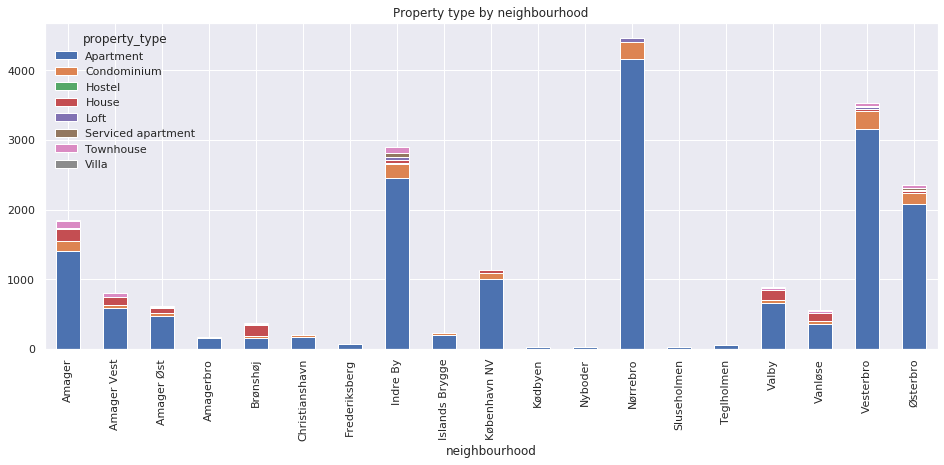

In [131]:
# Plot the property type count per neighbourhood
prop_neigh_city = prop_neigh_city[prop_neigh_city['count(id)']>10]
prop_neigh_city.pivot(index='neighbourhood',columns='property_type',\
                      values='count(id)').plot(kind='bar',figsize=(16,6),stacked=True)
plt.title('Property type by neighbourhood')
plt.show()

## Prices
Compute the minimum, maximum and average listing price in your city. 


#### Description of Implementation of Prices-section
*We see that 20,526 listings appears in Copenhagen. The price is cast to double, so that it is ready to use for some statistics. The minimum, maximum and average price of the Copenhagen is computed. It should be noted that we have data with a price of 0, that could indicate a need for removing price outliers. The distribution of the prices is also visualized and here it is clear that both the extremely low and high prices are outliers and only occurs very rarely.*

*At the end of the section we compute a new attribute called value, that says something about the value for money, based on the average rating score and price per night. In order to show the top three value for money listings in each Copenhagen neighbourhood, we implemented a window function that orders by value and is used for filtering.*

In [136]:
# Listings in Copenhagen
df_cph = df.filter(extract_cph_udf(df.city))
df_cph.count()

20526

In [137]:
# Cast price into double and remove $
df_cph = df_cph.withColumn("price",f.expr("substring(price, 2, length(price))"))
df_cph = df_cph.withColumn("price", f.regexp_replace(f.col("price"), ",", ""))
df_cph = df_cph.withColumn("price",df_cph["price"].cast(DoubleType()))

In [138]:
# Min, max and average price data frame
print("Basic statistics for Copenhagen")
df_cph.select(f.avg('price').alias("Average price"), f.max('price').alias("Max price"), f.min('price').alias("Min price")).show()

Basic statistics for Copenhagen
+-----------------+---------+---------+
|    Average price|Max price|Min price|
+-----------------+---------+---------+
|815.9543505797525|  59999.0|      0.0|
+-----------------+---------+---------+



Compute and visualize the distribution of listing prices in your city.

In [139]:
sns.set_palette("cubehelix", 4)
plt.style.use(['seaborn-whitegrid'])
sns.set(rc={'figure.figsize':(16,6)})

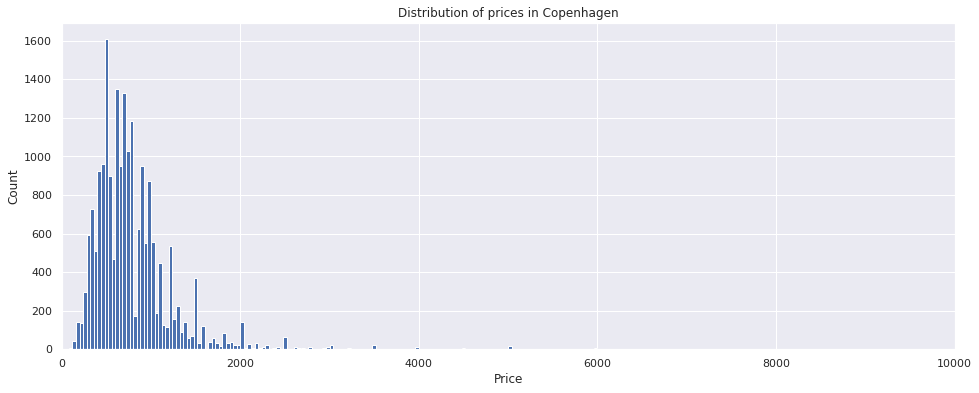

In [140]:
df_city_p = df_cph.toPandas()
plt.hist(df_city_p.price,bins=1500)
plt.title('Distribution of prices in Copenhagen')
plt.xlabel('Price')
plt.xlim(0,10000)
plt.ylabel('Count');

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

In [144]:
# Create new value column
df_value = df_cph.withColumn("review_scores_rating",df_cph["review_scores_rating"].cast(DoubleType()))
df_value = df_value.withColumn("value",f.lit(f.col("review_scores_rating")/f.col("price")))

In [145]:
# Window function to select top three
sorted_by_value = Window.partitionBy('neighbourhood').orderBy(f.desc('value'))
# Apply window function
ranked_by_value = df_value.withColumn('value_rank', f.rank().over(sorted_by_value))
# Filter top three
ranked_df = ranked_by_value.filter(f.col('value_rank') <= 3).drop('value_rank').orderBy('neighbourhood', f.desc('value'))

In [146]:
ranked_df.show()

+--------+-------+-----------+--------------+-------------+-----+--------------------+-------------------+
|      id|country|       city| neighbourhood|property_type|price|review_scores_rating|              value|
+--------+-------+-----------+--------------+-------------+-----+--------------------+-------------------+
| 5710617|Denmark| Copenhagen|        Amager|    Apartment|150.0|               100.0| 0.6666666666666666|
|23337696|Denmark|  København|        Amager|    Apartment|178.0|               100.0| 0.5617977528089888|
|22900213|Denmark|  København|        Amager|    Apartment|178.0|               100.0| 0.5617977528089888|
|27815787|Denmark| Copenhagen|   Amager Vest|    Apartment| 75.0|               100.0| 1.3333333333333333|
| 4831559|Denmark| Copenhagen|   Amager Vest|    Apartment| 96.0|                90.0|             0.9375|
|37172149|Denmark|  København|   Amager Vest|    Apartment|177.0|               100.0| 0.5649717514124294|
|13746265|Denmark|  København|    Ama

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

#### Description of Trends
*In this section we first join (left) the Review data on the Listing data (filtered on Copenhagen) and then count the number of reviews pr. unique date using group by. The data is transformed to Pandas Dataframe and the Date column is changed to Pandas Datetime type. We then sum the number of reviews pr. month, again using groupby and plot the result. To vizualize the popularity of neighbourhoods over time we do almost the same as just described. The only difference is that we also group by "neighbourhood". This is done to show the number of reviews pr. neighbourhood. Lastly, to show seasonality we sum the number of reviews pr. month and plot the result.*

In [147]:
# left-join Review-data on Listing-data on listing_id and id
df_join = df_cph.join(df_review, (df_cph.id == df_review.listing_id), how='left')
# Groupby date count reviews
df_plot = df_join.groupby('date').agg(f.count('review_id')).toPandas()

In [148]:
# To datetime and groupby date at month level
df_plot.date = pd.to_datetime(df_plot.date)
df_plot = df_plot.groupby(pd.Grouper(key='date',freq='M')).sum()

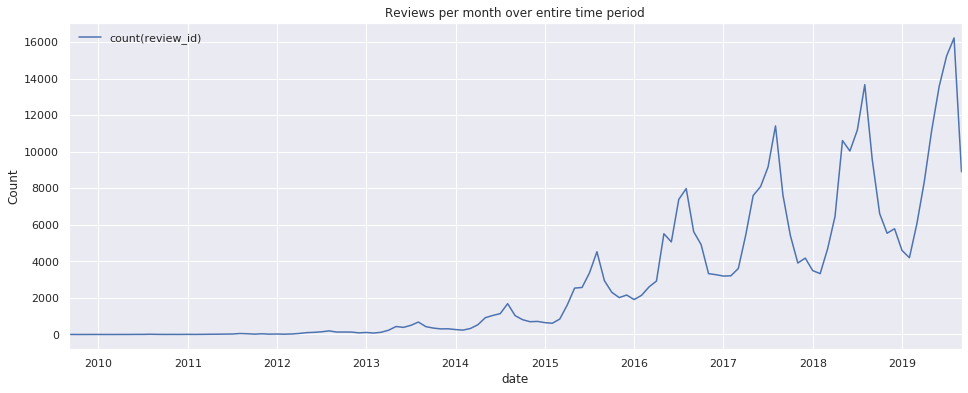

In [149]:
# Plotting number of reveis over entire time period
df_plot.plot(figsize=(16,6))

plt.title('Reviews per month over entire time period')
plt.ylabel('Count')
plt.show()

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

In [153]:
# Group by date and neighbourhood
df_plot = df_join.groupby('date','neighbourhood').agg(f.count('review_id')).toPandas()

In [154]:
# To datetime and group by date at month level
df_plot.date = pd.to_datetime(df_plot.date)
df_plot = df_plot.groupby(['neighbourhood',pd.Grouper(key='date',freq='M')]).sum().reset_index()

In [155]:
df_plot = df_plot.pivot(index='date',columns='neighbourhood',\
                      values='count(review_id)')
df_plot = df_plot[df_plot.index.notnull()].reset_index()
df_plot = df_plot.fillna(0)

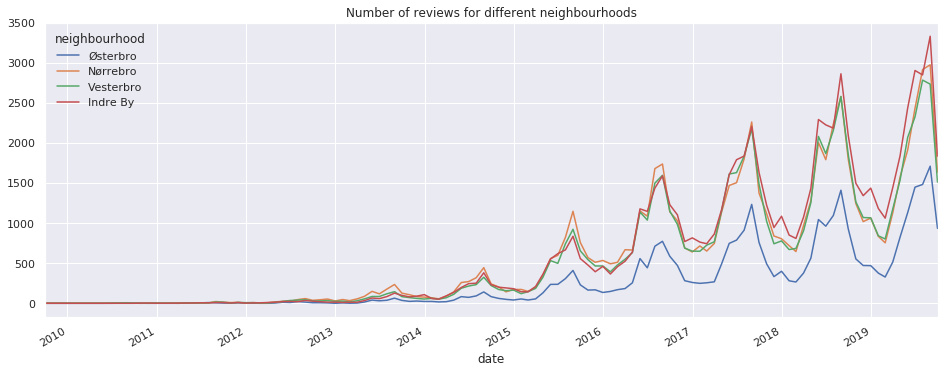

In [158]:
# Plot review count of four largest neighbourhoods
df_plot.plot(x='date', y=['Østerbro','Nørrebro','Vesterbro','Indre By'],figsize=(16,6))
plt.title('Number of reviews for different neighbourhoods')
plt.show()

Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

In [115]:
# Group by date
df_plot = df_join.groupby('date').agg(f.count('review_id')).toPandas()
# To datetime and select month
df_plot.date = pd.to_datetime(df_plot.date)
df_plot['date'] = df_plot['date'].dt.month

# Group by name of month
df_plot = df_plot.groupby('date',as_index=False).sum()

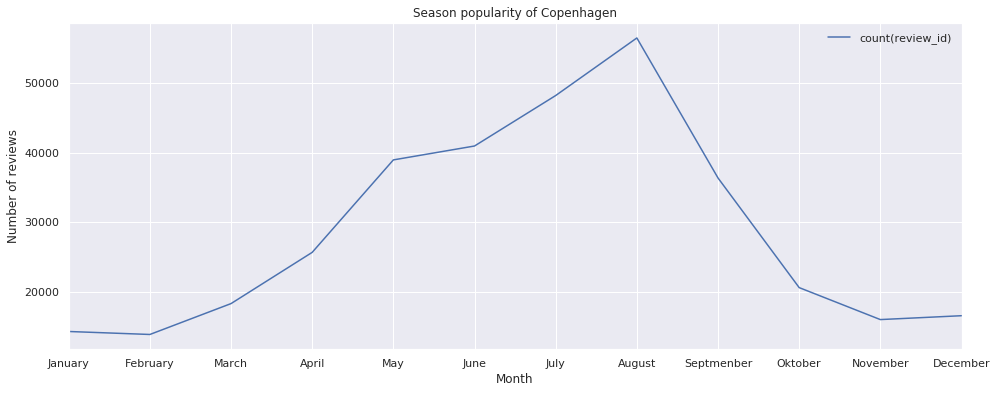

In [122]:
# Plot season popularity
fig = df_plot.plot(x='date', y='count(review_id)',figsize=(16,6))
fig.set_xticks(np.arange(1,13))
fig.set_xticklabels(['January','February','March','April','May','June','July','August','Septmenber','Oktober','November','December'])
plt.title('Season popularity of Copenhagen')
plt.xlabel('Month')
plt.ylabel('Number of reviews')
plt.show()

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

#### Description of Reviews

*To assess the possitivity score for each word in the reviews, we are merging the listing and review dataframe, such that all reviews are getting the average score for the respective listing. Before analyzing the words, we are handling things that might tweak the correct positivity-score of a given word. This includes things like lowercasing and removal of symbols.*

*The weight measure is calculated by exploding each review such that every word in the `comments` column gets its own row. This means, that every review, which initially consitis of one row, gets exploded into as many rows as the number of words in the review comment. Thereby, we will have distinct words with the score for that particular listing. We can then group by words and use an aggregate mean to get the final score for each word.*

*We are ignoring all words which occurs less than 500 times in total, in order to ensure that words are actually having an impotance before they can occur as a positive word. This hinders, that a word which are mentioned very few times in a review that has been very positive, will outweigh other more relevant words.*

In [194]:
#Importing packages
from pyspark.sql.functions import lower, regexp_replace, split
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import udf

In [195]:
# Load listings
dfl = spark.read.option('header', True).option('inferSchema', True).option('multiline', True).option('escape','"').csv('../listings.csv')
# Load reviews
dfr = spark.read.option('header', True).option('inferSchema', True).option('multiline', True).option('escape','"').csv('../reviews.csv')

In [196]:
#Selecting the relevant columns in the two dataframes
dfr = dfr.select('listing_id','comments')
dfl = dfl.select('id','review_scores_rating')

After selecting the correct columns, we have to join the two dataframes. As we do not have a rating for each of the reviews, each review will get the average rating which is contained in the listing dataset. 

In [197]:
#Joining the reviews and listings on listing ID
df = dfr.join(dfl, (f.col('listing_id') == f.col('id')), 'left')

In [198]:
#Cleaning text in the comments column 
def clean_text(c):
    c = lower(c)
    c = regexp_replace(c, "[^a-zA-Z0-9\\s]", "")
    return c

df = df.withColumn("text_clean", clean_text(f.col("comments")))

In [199]:
#Creating a tokenizer and tokenizing all the comments, enabling us to analyze each word seperately 
tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
df = tokenizer.transform(df)

In [200]:
#Defining a stopwords remover
remover = StopWordsRemover()
stopwords = remover.getStopWords() 

#Defining the input column on which the stopwords remover is applied and what to call the output column
remover.setInputCol("words")
remover.setOutputCol("comments_wo_stopwords")

#Apply the stopwords remover to the dataframe 
df = remover.transform(df)

In [202]:
#Displaying results of which words are the most positive given the reviews
df.withColumn('Word', f.explode(f.col('comments_wo_stopwords'))).select('review_scores_rating','Word')\
    .groupBy('Word').agg(f.mean('review_scores_rating').alias("Average word-review"), f.count('Word').alias("Word count"))\
    .sort('Average word-review', ascending=False)\
    .filter(f.col('Word count') > 500)\
    .show()

+------------+-------------------+----------+
|        Word|Average word-review|Word count|
+------------+-------------------+----------+
|      highly|  95.71049840933192|       943|
|        home|   95.6472081218274|      1182|
|   wonderful|  95.49268841394826|       889|
|   beautiful|  95.41916167664671|       835|
|        back|  95.38628762541806|       598|
|  experience|  95.33395176252318|       539|
|     perfect|  95.32115942028986|      1725|
|        gave|  95.28654124457309|       691|
|        even|  95.24183006535948|       918|
|       quiet|  95.23913043478261|      1012|
|        best|   95.2211350293542|       511|
| restaurants|   95.2008501594049|       941|
|    spacious|  95.18773234200744|       538|
|        feel|   95.1842105263158|       570|
|neighborhood|             95.165|       600|
|  definitely|  95.14994829369184|       967|
|      stayed|  95.11324041811847|       574|
|      lovely|  95.10166520595969|      1141|
|     staying|  95.09146341463415|

As we see above, the words are very relevant from the perspective of an AirBnB review. Words like "home", "beautiful", "quiet", "restaurants", are all words we associate with positive holiday experiences. 